In [6]:
import os
import gzip

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.data import Field, BucketIterator, Dataset, Example

import spacy

import numpy as np
import random
import math
import time

In [7]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
# Подгрузим модели для токенизации de - для немецкого языка, en - для английского
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

# Делаем токенизацию, но возвращаем список с исходными словами
def tokenize_de(text):
    return [tok.text for tok in spacy_de(text)][::-1]

def tokenize_en(text):
    return [tok.text for tok in spacy_en(text)]


In [9]:
# тут мы определяем поля SRC и TRG, они отвечают за то как именно будет 
# обрабатываться текст на англ и немецком

SRC = Field(tokenize = tokenize_de, init_token = '<sos>', eos_token = '<eos>', lower = True, include_lengths=True)
TRG = Field(tokenize = tokenize_en, init_token = '<sos>', eos_token = '<eos>', lower = True)

In [10]:
def read_gzip(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        return [line.strip() for line in f]

# Путь к датасету
data_path = 'multi30k-dataset/data/task1/raw/'

# Загрузка данных
train_src = read_gzip(os.path.join(data_path, 'train.de.gz'))
train_trg = read_gzip(os.path.join(data_path, 'train.en.gz'))
val_src = read_gzip(os.path.join(data_path, 'val.de.gz'))
val_trg = read_gzip(os.path.join(data_path, 'val.en.gz'))
test_src = read_gzip(os.path.join(data_path, 'test_2016_flickr.de.gz'))
test_trg = read_gzip(os.path.join(data_path, 'test_2016_flickr.en.gz'))

In [11]:
def create_examples(src_data, trg_data, src_field, trg_field):
    '''
    Создает список объектов Example, которые используются для представления
    параллельных примеров исходного и целевого языка
    src_data, trg_data - данные языков
    src_field, trg_field - поля для обработки данных
    '''
    examples = []
    for src, trg in zip(src_data, trg_data):
        examples.append(Example.fromlist([src, trg], fields=[('src', src_field), ('trg', trg_field)]))
    return examples

train_examples = create_examples(train_src, train_trg, SRC, TRG)
val_examples = create_examples(val_src, val_trg, SRC, TRG)
test_examples = create_examples(test_src, test_trg, SRC, TRG)

fields = [('src', SRC), ('trg', TRG)]

train_data = Dataset(examples=train_examples, fields=fields)
valid_data = Dataset(examples=val_examples, fields=fields)
test_data = Dataset(examples=test_examples, fields=fields)

SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [12]:
f = train_data[6]
print(f.src, f.trg, sep='\n')

['.', 'an', 'löwen', 'ausgestopften', 'einen', 'lächelt', 'mann', 'ein']
['a', 'man', 'is', 'smiling', 'at', 'a', 'stuffed', 'lion']


In [13]:
BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch = True,
    sort_key = lambda x: len(x.src),
    device=device
)

cuda


In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        '''
        input_dim - размер входного словаря
        emb_dim - размерность эмбеддингов
        enc_hid_dim - размерность скрытого состояния энкодера
        dec_hid_dim - ращмерность скрытого состояния декодера
        dropout - вероятность применения dropout
        '''
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        embedded = self.dropout(self.embedding(src))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'))
                
        packed_outputs, hidden = self.rnn(packed_embedded)

        'pad_packed_outputs возвращает output и их длины'
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

        return outputs, hidden
        

In [15]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        '''
        enc_hid_dim  - размерность скрытого состояния энкодера
        dec_hid_dim - размерность скрытого состояния декодера
        nn.Linear - лейныенй слои для вычисления внимания
        '''
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        '''
        hidden - текущее скрытое состояние декодера
        encoder_outputs  - выходы энкодера
        mask - маска позволяющаа игнорировать падинг токены
        '''
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 

        attention = self.v(energy).squeeze(2)
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [16]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        '''
        output_dim - размер выходного словаря
        emb_dim - размерность эмбедингов
        enc_hid_dim - размерность скрыторого состояния энкодера
        dec_hid_dim - размерность скрытого состояния декодера
        dropout - вероятность применения dropout
        attention - механизм внимания
        '''

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        
        a = self.attention(hidden, encoder_outputs, mask)
        
        a = a.unsqueeze(1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        weighted = torch.bmm(a, encoder_outputs)
        
        weighted = weighted.permute(1, 0, 2)
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        input = trg[0,:]
        
        mask = self.create_mask(src)
                
        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force else top1
            
        return outputs

In [18]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [19]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [21]:
optimizer = optim.Adam(model.parameters())

In [22]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [26]:
from tensorboardX import SummaryWriter
import datetime

In [27]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, src_len = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0)

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [30]:
import torch
print(torch.cuda.is_available())  # Должно вывести True, если CUDA доступна

True


In [31]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
writer = SummaryWriter()

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    writer.add_scalar("Train Loss", train_loss, epoch+1)
    writer.add_scalar("Train PPL", math.exp(train_loss), epoch+1)
    writer.add_scalar("Val. Loss", valid_loss, epoch+1)
    writer.add_scalar("Val. PPL", math.exp(valid_loss), epoch+1)

writer.close()

Epoch: 01 | Time: 5m 15s
	Train Loss: 5.076 | Train PPL: 160.149
	 Val. Loss: 4.811 |  Val. PPL: 122.881
Epoch: 02 | Time: 1m 13s
	Train Loss: 4.078 | Train PPL:  59.013
	 Val. Loss: 4.094 |  Val. PPL:  59.952
Epoch: 03 | Time: 1m 18s
	Train Loss: 3.290 | Train PPL:  26.845
	 Val. Loss: 3.560 |  Val. PPL:  35.168
Epoch: 04 | Time: 1m 19s
	Train Loss: 2.798 | Train PPL:  16.411
	 Val. Loss: 3.303 |  Val. PPL:  27.182
Epoch: 05 | Time: 1m 14s
	Train Loss: 2.422 | Train PPL:  11.270
	 Val. Loss: 3.273 |  Val. PPL:  26.390
Epoch: 06 | Time: 1m 28s
	Train Loss: 2.147 | Train PPL:   8.560
	 Val. Loss: 3.224 |  Val. PPL:  25.129
Epoch: 07 | Time: 1m 21s
	Train Loss: 1.914 | Train PPL:   6.777
	 Val. Loss: 3.208 |  Val. PPL:  24.741
Epoch: 08 | Time: 1m 12s
	Train Loss: 1.720 | Train PPL:   5.585
	 Val. Loss: 3.289 |  Val. PPL:  26.818
Epoch: 09 | Time: 1m 12s
	Train Loss: 1.585 | Train PPL:   4.882
	 Val. Loss: 3.306 |  Val. PPL:  27.267
Epoch: 10 | Time: 1m 10s
	Train Loss: 1.478 | Train PPL

In [32]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.199 | Test PPL:  24.502 |


Вывод


In [33]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [47]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src[::-1]}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


predicted trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'fighting', '.', '<eos>']


C:\Users\amtal\AppData\Local\Temp\ipykernel_27360\4023902588.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\amtal\AppData\Local\Temp\ipykernel_27360\4023902588.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)


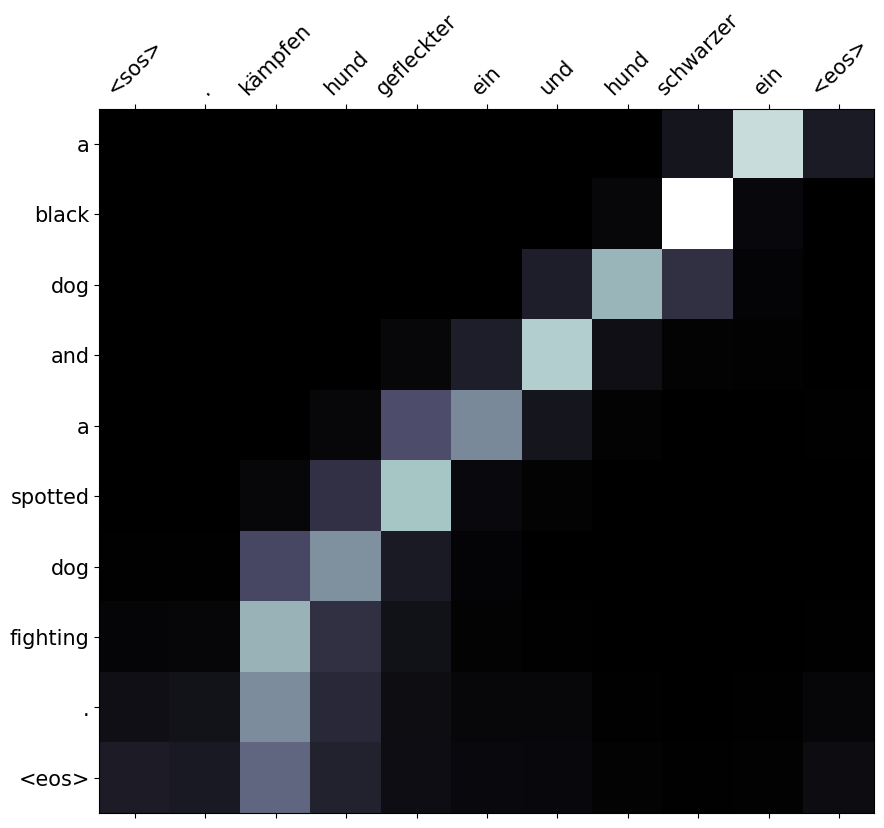

In [48]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [44]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['.', 'cello', 'ihrem', 'auf', 'lied', 'ein', 'spielt', 'frau', 'eine']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


In [45]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [46]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.94
